In [1]:
!pip install kaggle  # Install Kaggle CLI
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip celeba-dataset.zip -d /content/dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: /content/dat

In [20]:
!pip install -q --upgrade torch_snippets
from torch_snippets import *
import torchvision, torch
from torchvision import transforms
import torchvision.utils as vutils
import cv2, numpy as np, pandas as pd
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
from torch.nn import BCELoss
import glob

In [21]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + \
 'haarcascade_frontalface_default.xml')

In [24]:
os.makedirs('cropped_faces', exist_ok=True)

# Get image paths
import random
images = random.sample(glob.glob('/content/dataset/img_align_celeba/img_align_celeba/*.jpg'), 1000)

for i, path in enumerate(images):
    img = cv2.imread(path)
    if img is None:
        continue
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        cropped_face = img[y:y+h, x:x+w]
        out_path = f'cropped_faces/{i}.jpg'
        cv2.imwrite(out_path, cropped_face)
        break  # Save only one face per image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# import os
# save_dir = '/content/drive/MyDrive/cropped_faces'
# os.makedirs(save_dir, exist_ok=True)

# cv2.imwrite(f'{save_dir}/{i}.jpg', cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

# # (drive.mount('/content/drive')), and your cropped faces will be available in '/content/drive/MyDrive/cropped_faces/'.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
#@ transforms:
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [26]:
#@ DataLoader:
from torch.utils.data import Dataset, DataLoader
class Faces(Dataset):
  def __init__(self, folder):
    super().__init__()
    self.folder=folder
    self.images=sorted(Glob(folder))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, ix):
    image_path=self.images[ix]
    image=Image.open(image_path)
    image=transform(image)
    return image


In [27]:
dataset=Faces(folder='cropped_faces/')

In [28]:
dataloader=DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [29]:
def weights_init(m):
  classname=m.__class__.__name__ #checks what type of layer are we dealing
  if classname.find('Conv')!=-1:
    nn.init.normal_(m.weight.data, 0.0, 0.02) #0.0=mean, 0.02=std
  elif classname.find('BatchNorm')!= -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [30]:
#@ discriminator:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model=nn.Sequential(
        nn.Conv2d(3, 64, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64, 64*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64*2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64*4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64*8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64*8, 1, 4, 1, bias=False),
        nn.Sigmoid()
    )
    self.apply(weights_init)

  def forward(self, input):
    return self.model(input)

In [31]:
#@ Generator model class that generates fake images:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.model=nn.Sequential(
        nn.ConvTranspose2d(100, 64*8, 4, 1, 0, bias=False), #output=512, feature map= 4x4
        nn.BatchNorm2d(64*8),
        nn.ReLU(True),
        nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False), #output=256, feature map= 8x8
        nn.BatchNorm2d(64*4),
        nn.ReLU(True),
        nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False), #output=128,feature map= 16x16
        nn.BatchNorm2d(64*2),
        nn.ReLU(True),
        nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False),#output=64, feature map=32x32
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False), #output=3, feature map=64x64
        nn.Tanh()
    )
    self.apply(weights_init)

  def forward(self,input): return self.model(input)

In [32]:
#@ Creating objects for different purpose:
import torch.optim as optim

discriminator=Discriminator().to(device)
generator=Generator().to(device)
loss=nn.BCELoss()
d_optimizer=optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer=optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5,0.999))

In [33]:
#@ function to train generator and discriminator:

def discriminator_train_step(real_data, fake_data):
  d_optimizer.zero_grad()
  prediction_real=discriminator(real_data)
  error_real=loss(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
  error_real.backward()
  prediction_fake=discriminator(fake_data)
  error_fake=loss(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
  error_fake.backward()
  d_optimizer.step()
  return error_real + error_fake

In [34]:
def generator_train_step(fake_data):
  g_optimizer.zero_grad()
  prediction=discriminator(fake_data)
  error=loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
  error.backward()
  g_optimizer.step()
  return error

Epoch [1/25], Step [240/240], d_loss: 2.1052, g_loss: 8.6268
Epoch [1/25] completed. Avg d_loss: 0.6630, Avg g_loss: 9.0794
Epoch [2/25], Step [240/240], d_loss: 1.4029, g_loss: 5.8826
Epoch [2/25] completed. Avg d_loss: 0.6496, Avg g_loss: 5.7537

Epoch [3/25] completed. Avg d_loss: 0.6167, Avg g_loss: 5.9080

Epoch [4/25] completed. Avg d_loss: 0.5633, Avg g_loss: 5.4575

Epoch [5/25] completed. Avg d_loss: 0.5596, Avg g_loss: 4.7372

Epoch [6/25] completed. Avg d_loss: 0.6071, Avg g_loss: 4.4373

Epoch [7/25] completed. Avg d_loss: 0.6098, Avg g_loss: 3.9735
Epoch [8/25], Step [240/240], d_loss: 0.8665, g_loss: 6.9008
Epoch [8/25] completed. Avg d_loss: 0.6556, Avg g_loss: 3.8413

Epoch [9/25] completed. Avg d_loss: 0.5932, Avg g_loss: 3.6961

Epoch [10/25] completed. Avg d_loss: 0.6254, Avg g_loss: 3.5940
Epoch [11/25], Step [240/240], d_loss: 0.5995, g_loss: 4.9607
Epoch [11/25] completed. Avg d_loss: 0.6678, Avg g_loss: 3.4840
Epoch [12/25], Step [240/240], d_loss: 0.6179, g_loss

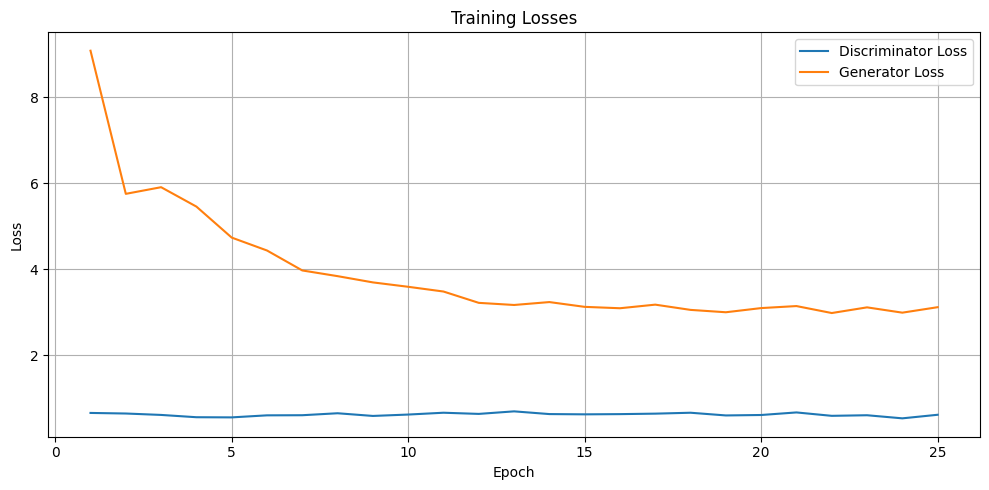

In [35]:
import matplotlib.pyplot as plt

# Lists to store average losses per epoch
d_losses = []
g_losses = []

for epoch in range(25):
    N = len(dataloader)
    total_d_loss = 0
    total_g_loss = 0

    for i, images in enumerate(dataloader):
        real_data = images.to(device)

        # Train Discriminator
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        total_d_loss += d_loss.item()

        # Train Generator
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device))
        g_loss = generator_train_step(fake_data)
        total_g_loss += g_loss.item()

        print(f"Epoch [{epoch+1}/25], Step [{i+1}/{N}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}", end='\r')

    avg_d_loss = total_d_loss / N
    avg_g_loss = total_g_loss / N

    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)

    print(f"\nEpoch [{epoch+1}/25] completed. Avg d_loss: {avg_d_loss:.4f}, Avg g_loss: {avg_g_loss:.4f}")

# Plotting losses after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, 26), d_losses, label='Discriminator Loss')
plt.plot(range(1, 26), g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


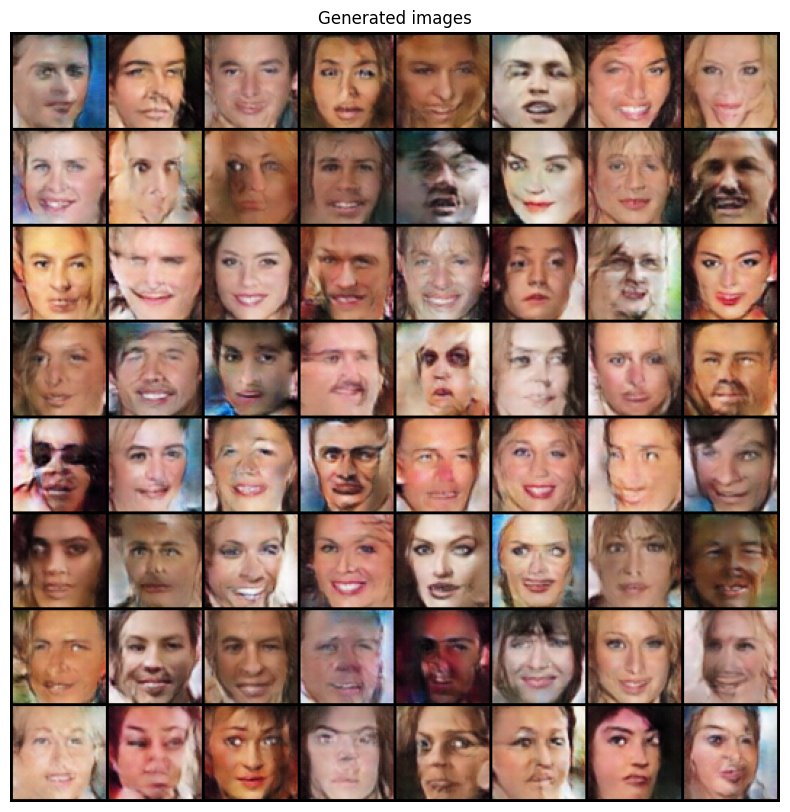

In [36]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')

In [ ]:
!wget https://mmlab.ie.cuhk.edu.hk/projects/CelebA/CelebA_Dialog.html